In [157]:
!pip install dataframe-image
!pip install fpdf

In [158]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, average_precision_score, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
from fpdf import FPDF
from PIL import Image


In [159]:
# Sample case IDs
case_ids = [f'case_{i+1}' for i in range(1000)]

# Attributes
attributes = ['comorbidity_diabetes', 'comorbidity_hypertension', 'medication_aspirin', 'mortality_30_day']

# Generate ground truth (binary)
np.random.seed(42)
ground_truth_data = {'case_id': case_ids}
for attr in attributes:
    ground_truth_data[attr] = np.random.choice([0,1], size=1000, p=[0.7,0.3])
ground_truth_df = pd.DataFrame(ground_truth_data)
ground_truth_df.to_csv('ground_truth.csv', index=False)

# Generate probabilistic model outputs with noise
def generate_model_output_probs(gt_df, noise_level=0.1, model_name='model'):
    np.random.seed(hash(model_name) % 2**32)
    model_data = {'case_id': gt_df['case_id']}
    for attr in attributes:
        probs = gt_df[attr] * (1 - noise_level) + (1 - gt_df[attr]) * noise_level
        probs = probs + np.random.normal(0, noise_level/2, size=len(probs))
        probs = np.clip(probs, 0, 1)
        model_data[attr] = probs
    return pd.DataFrame(model_data)

model_1_df = generate_model_output_probs(ground_truth_df, noise_level=0.35, model_name='Model_1')
model_2_df = generate_model_output_probs(ground_truth_df, noise_level=0.37, model_name='Model_2')
model_3_df = generate_model_output_probs(ground_truth_df, noise_level=0.39, model_name='Model_3')

model_1_df.to_csv('model_output_1.csv', index=False)
model_2_df.to_csv('model_output_2.csv', index=False)
model_3_df.to_csv('model_output_3.csv', index=False)


In [160]:

# Load data
gt_df = pd.read_csv('ground_truth.csv')
model_outputs = {
    'Model_1': pd.read_csv('model_output_1.csv'),
    'Model_2': pd.read_csv('model_output_2.csv'),
    'Model_3': pd.read_csv('model_output_3.csv'),
}

attributes = ['comorbidity_diabetes', 'comorbidity_hypertension', 'medication_aspirin', 'mortality_30_day']

def compute_metrics_at_threshold(gt, probs, threshold, attribute):
    y_true = gt[attribute]
    y_pred = (probs[attribute] >= threshold).astype(int)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    return precision, recall, f1, accuracy

def plot_pr_curve(gt, probs, attribute, model_name):
    y_true = gt[attribute]
    y_scores = probs[attribute]
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)

    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label=f'{model_name} (AP={ap:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {attribute}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [161]:
def plot_pr_curves_all_models(gt, model_outputs, attribute, filename='pr_curve'):
    plt.figure(figsize=(8,6))

    for model_name, probs in model_outputs.items():
        y_true = gt[attribute]
        y_scores = probs[attribute]

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        ap = average_precision_score(y_true, y_scores)

        plt.plot(recall, precision, label=f'{model_name} (AP={ap:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves for "{attribute}"')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.savefig(f'{filename}.png')
    plt.show()
    plt.close()

def evaluate_model(gt_df, pred_df, thresholds=None):
    """
    Compute precision, recall, f1, accuracy per attribute.

    Parameters:
    - gt_df: Ground truth DataFrame
    - pred_df: Model predictions DataFrame (with probabilities)
    - thresholds: dict, optional
        A dictionary mapping attribute names to thresholds.
        Example: {'comorbidity_diabetes': 0.5, 'mortality_30_day': 0.6}

    Returns:
    - DataFrame with metrics per attribute
    """
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
    import numpy as np
    import pandas as pd

    # Define columns to always exclude (identifiers)
    exclude_cols = ['case_id']

    # Base clinical attributes to evaluate
    clinical_attrs = ['comorbidity_diabetes', 'comorbidity_hypertension',
                      'medication_aspirin', 'mortality_30_day']

    results = []
    for attr in clinical_attrs:
        if attr not in gt_df.columns or attr not in pred_df.columns:
            continue  # skip if attribute missing in either df

        y_true = gt_df[attr]
        y_prob = pred_df[attr]

        # Get threshold for this attribute, default to 0.5 if not provided
        threshold = thresholds.get(attr, 0.5) if thresholds else 0.5

        # Binarize probabilistic predictions
        y_pred = (y_prob >= threshold).astype(int)

        # Compute metrics
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)

        results.append({
            'Attribute': attr,
            'Threshold': threshold,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'Accuracy': accuracy,
            'MAE': np.nan  # Placeholder for numeric attributes if added later
        })

    return pd.DataFrame(results)




In [162]:
metrics_dfs = {}

for model_name, pred_df in model_outputs.items():
    metrics_df = evaluate_model(gt_df, pred_df)
    metrics_df['Model'] = model_name
    metrics_dfs[model_name] = metrics_df

# Combine all results into one DataFrame
combined_metrics = pd.concat(metrics_dfs.values(), ignore_index=True)

# Pivot for better readability: rows=Attributes, columns=Model + metric
summary_table = combined_metrics.pivot(index='Attribute', columns='Model')
print(summary_table)

                         Threshold                 Precision            \
Model                      Model_1 Model_2 Model_3   Model_1   Model_2   
Attribute                                                                
comorbidity_diabetes           0.5     0.5     0.5  0.640580  0.541063   
comorbidity_hypertension       0.5     0.5     0.5  0.648649  0.564286   
medication_aspirin             0.5     0.5     0.5  0.639175  0.577670   
mortality_30_day               0.5     0.5     0.5  0.606684  0.571809   

                                      Recall                            F1  \
Model                      Model_3   Model_1   Model_2   Model_3   Model_1   
Attribute                                                                    
comorbidity_diabetes      0.503916  0.767361  0.777778  0.670139  0.698262   
comorbidity_hypertension  0.545012  0.781759  0.771987  0.729642  0.709010   
medication_aspirin        0.498728  0.797428  0.765273  0.630225  0.709585   
mortality_30_

In [163]:

def plot_heatmap(summary_df, metric="F1", figsize=(10, 6), cmap="Spectral"):
    """
    Plot a heatmap of a chosen metric across models and attributes with color scale fixed between 0 and 1.

    Parameters:
    - summary_df: DataFrame with columns ['Model', 'Attribute', 'Precision', 'Recall', 'F1', 'Accuracy']
    - metric: Which metric to visualize ("Precision", "Recall", "F1", "Accuracy")
    - figsize: Tuple for figure size
    - cmap: Colormap for heatmap (default "Spectral" for colorblind-friendly)
    """
    if metric not in ["Precision", "Recall", "F1", "Accuracy"]:
        raise ValueError(f"Metric '{metric}' is not valid. Choose from Precision, Recall, F1, Accuracy.")

    pivot_df = summary_df.pivot(index="Attribute", columns="Model", values=metric)

    plt.figure(figsize=figsize)
    sns.heatmap(
        pivot_df,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        cbar_kws={'label': metric},
        linewidths=0.5,
        linecolor='gray',
        vmin=0,    # force color scale min
        vmax=1     # force color scale max
    )
    plt.title(f"{metric} Heatmap by Attribute and Model", fontsize=14)
    plt.xlabel("Model")
    plt.ylabel("Attribute")
    plt.tight_layout()
    plt.show()


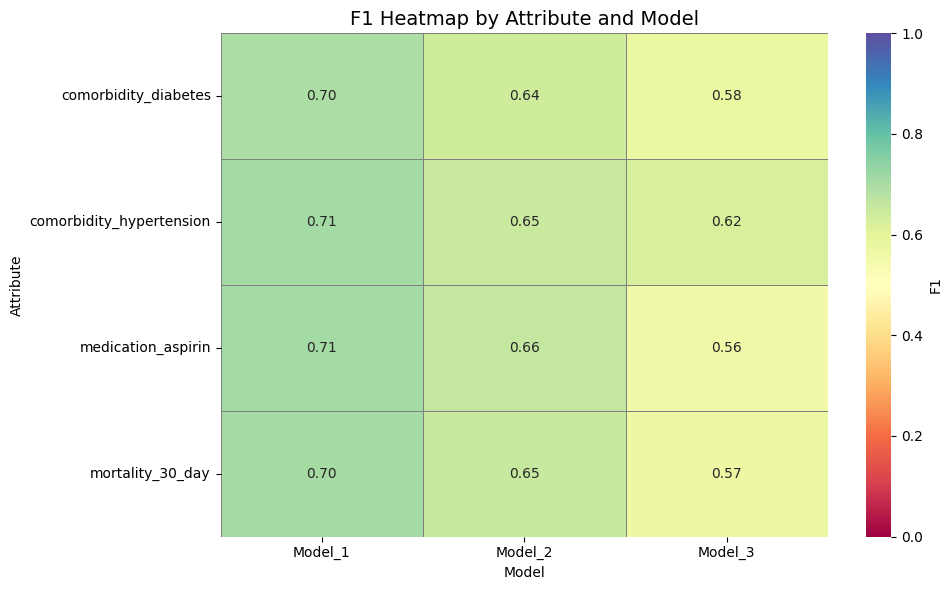

In [164]:
plot_heatmap(combined_metrics, metric="F1", figsize=(10, 6), cmap="Spectral")

In [165]:


def plot_horizontal_bar(summary_df, metric="F1", figsize=(10, 6), filename='bar_chart'):
    """
    Plot a horizontal grouped bar chart of a chosen metric across attributes and models.

    Parameters:
    - summary_df: DataFrame with columns ['Model', 'Attribute', 'Precision', 'Recall', 'F1', 'Accuracy']
    - metric: Which metric to visualize ("Precision", "Recall", "F1", "Accuracy")
    - figsize: Tuple for figure size
    """
    if metric not in ["Precision", "Recall", "F1", "Accuracy"]:
        raise ValueError(f"Metric '{metric}' is not valid. Choose from Precision, Recall, F1, Accuracy.")

    # Pivot the data so rows = attributes, columns = models, values = metric
    pivot_df = summary_df.pivot(index="Attribute", columns="Model", values=metric)

    # Sort attributes by average metric value for better readability
    pivot_df['mean_metric'] = pivot_df.mean(axis=1)
    pivot_df = pivot_df.sort_values('mean_metric', ascending=True)
    pivot_df = pivot_df.drop(columns=['mean_metric'])

    attributes = pivot_df.index.tolist()
    models = pivot_df.columns.tolist()

    y_pos = np.arange(len(attributes))
    bar_height = 0.8 / len(models)  # bar thickness adjusted for number of models

    fig, ax = plt.subplots(figsize=figsize)

    for i, model in enumerate(models):
        # Calculate position for each model's bar within each attribute row
        positions = y_pos - 0.4 + i * bar_height + bar_height/2
        ax.barh(positions, pivot_df[model], height=bar_height, label=model)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(attributes)
    ax.set_xlim(0, 1)  # force x-axis between 0 and 1 for metric scale
    ax.set_xlabel(metric)
    ax.set_title(f"{metric} by Attribute and Model")
    ax.legend(title="Model")
    plt.tight_layout()
    plt.savefig(f'{metric} {filename}.png')
    plt.show()
    plt.close()


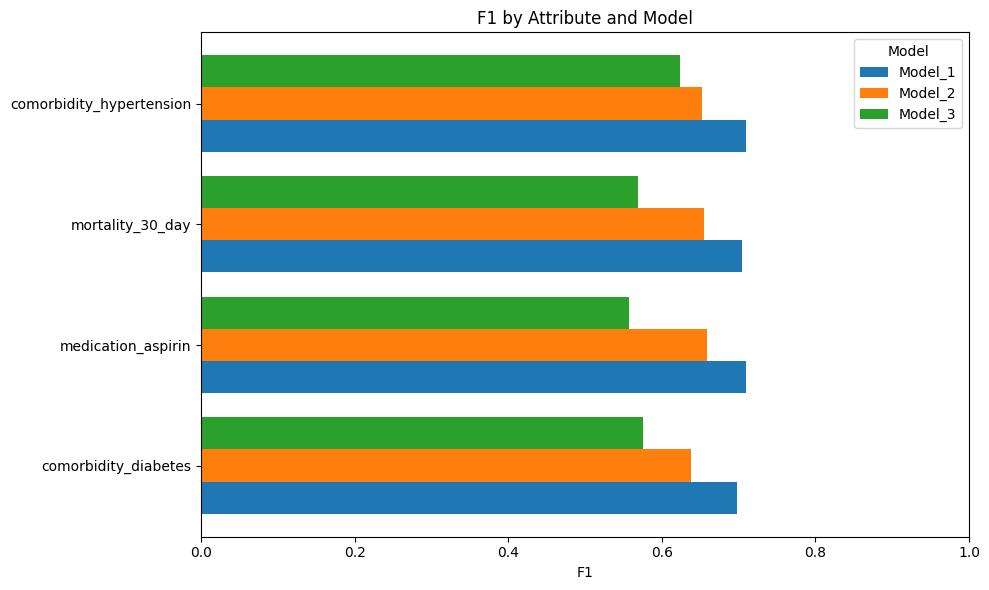

In [166]:
plot_horizontal_bar(combined_metrics, metric="F1", figsize=(10, 6))

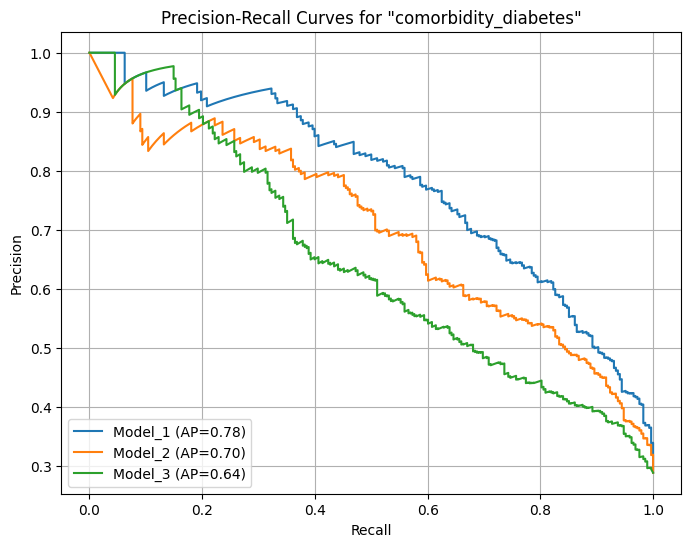

In [167]:
plot_pr_curves_all_models(gt_df, model_outputs, 'comorbidity_diabetes')

In [168]:


def summarize_metrics(gt, model_outputs, threshold):
    attributes = [col for col in gt.columns if col != 'case_id']
    rows = []

    for model_name, probs in model_outputs.items():
        for attr in attributes:
            y_true = gt[attr]
            y_scores = probs[attr]
            y_pred = (y_scores >= threshold).astype(int)

            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            accuracy = accuracy_score(y_true, y_pred)
            avg_prec = average_precision_score(y_true, y_scores)

            rows.append({
                'Model': model_name,
                'Attribute': attr,
                'Threshold': threshold,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Accuracy': accuracy,
                'Average Precision (AP)': avg_prec
            })

    summary_df = pd.DataFrame(rows)
    return summary_df

# Example usage:
threshold = 0.5
summary = summarize_metrics(ground_truth_df, model_outputs, threshold)
print(summary)


      Model                 Attribute  Threshold  Precision    Recall  \
0   Model_1      comorbidity_diabetes        0.5   0.640580  0.767361   
1   Model_1  comorbidity_hypertension        0.5   0.648649  0.781759   
2   Model_1        medication_aspirin        0.5   0.639175  0.797428   
3   Model_1          mortality_30_day        0.5   0.606684  0.839858   
4   Model_2      comorbidity_diabetes        0.5   0.541063  0.777778   
5   Model_2  comorbidity_hypertension        0.5   0.564286  0.771987   
6   Model_2        medication_aspirin        0.5   0.577670  0.765273   
7   Model_2          mortality_30_day        0.5   0.571809  0.765125   
8   Model_3      comorbidity_diabetes        0.5   0.503916  0.670139   
9   Model_3  comorbidity_hypertension        0.5   0.545012  0.729642   
10  Model_3        medication_aspirin        0.5   0.498728  0.630225   
11  Model_3          mortality_30_day        0.5   0.476077  0.708185   

          F1  Accuracy  Average Precision (AP)  
0

In [169]:
def styled_metrics_by_model(summary_df, filename='summary_metrics.png'):
    def color_rows_by_model(row):
        # Assign a color based on model name hash (consistent but different per model)
        colors = ['#E3F2FD', '#FFF3E0', '#E8F5E9', '#F3E5F5', '#FFEBEE']
        model_list = summary_df['Model'].unique()
        color_map = {model: colors[i % len(colors)] for i, model in enumerate(model_list)}
        return [f'background-color: {color_map[row["Model"]]}'] * len(row)

    styled = summary_df.style.apply(color_rows_by_model, axis=1) \
                              .background_gradient(subset=['Precision', 'Recall', 'F1', 'Accuracy', 'Average Precision (AP)'], cmap='RdYlGn', vmin=0, vmax=1) \
                              .format(precision=2) \
                              .set_properties(**{'text-align': 'center'}) \
                              .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
    display(styled)

    if filename:
        dfi.export(styled, filename, table_conversion="matplotlib")
        print(f"Styled table saved as: {filename}")


In [170]:
styled_metrics_by_model(summary)

,Model,Attribute,Threshold,Precision,Recall,F1,Accuracy,Average Precision (AP)
0,Model_1,comorbidity_diabetes,0.50,0.64,0.77,0.70,0.81,0.78
1,Model_1,comorbidity_hypertension,0.50,0.65,0.78,0.71,0.80,0.80
2,Model_1,medication_aspirin,0.50,0.64,0.80,0.71,0.80,0.79
3,Model_1,mortality_30_day,0.50,0.61,0.84,0.70,0.80,0.77
4,Model_2,comorbidity_diabetes,0.50,0.54,0.78,0.64,0.75,0.70
5,Model_2,comorbidity_hypertension,0.50,0.56,0.77,0.65,0.75,0.71
6,Model_2,medication_aspirin,0.50,0.58,0.77,0.66,0.75,0.70
7,Model_2,mortality_30_day,0.50,0.57,0.77,0.65,0.77,0.68
8,Model_3,comorbidity_diabetes,0.50,0.50,0.67,0.58,0.71,0.64
9,Model_3,comorbidity_hypertension,0.50,0.55,0.73,0.62,0.73,0.65


Styled table saved as: summary_metrics.png


In [171]:

def calculate_cohens_kappa(gt, model_outputs, threshold):
    attributes = [col for col in gt.columns if col != 'case_id']
    rows = []

    for model_name, probs in model_outputs.items():
        for attr in attributes:
            y_true = gt[attr]
            y_scores = probs[attr]
            y_pred = (y_scores >= threshold).astype(int)

            kappa = cohen_kappa_score(y_true, y_pred)

            rows.append({
                'Model': model_name,
                'Attribute': attr,
                'Threshold': threshold,
                'Cohen\'s Kappa': kappa
            })

    kappa_df = pd.DataFrame(rows)
    return kappa_df

# Example usage:
threshold = 0.5
kappa_summary = calculate_cohens_kappa(ground_truth_df, model_outputs, threshold)
print(kappa_summary)


      Model                 Attribute  Threshold  Cohen's Kappa
0   Model_1      comorbidity_diabetes        0.5       0.560192
1   Model_1  comorbidity_hypertension        0.5       0.562047
2   Model_1        medication_aspirin        0.5       0.556443
3   Model_1          mortality_30_day        0.5       0.561347
4   Model_2      comorbidity_diabetes        0.5       0.452038
5   Model_2  comorbidity_hypertension        0.5       0.460692
6   Model_2        medication_aspirin        0.5       0.470793
7   Model_2          mortality_30_day        0.5       0.490675
8   Model_3      comorbidity_diabetes        0.5       0.367218
9   Model_3  comorbidity_hypertension        0.5       0.420160
10  Model_3        medication_aspirin        0.5       0.321081
11  Model_3          mortality_30_day        0.5       0.351411


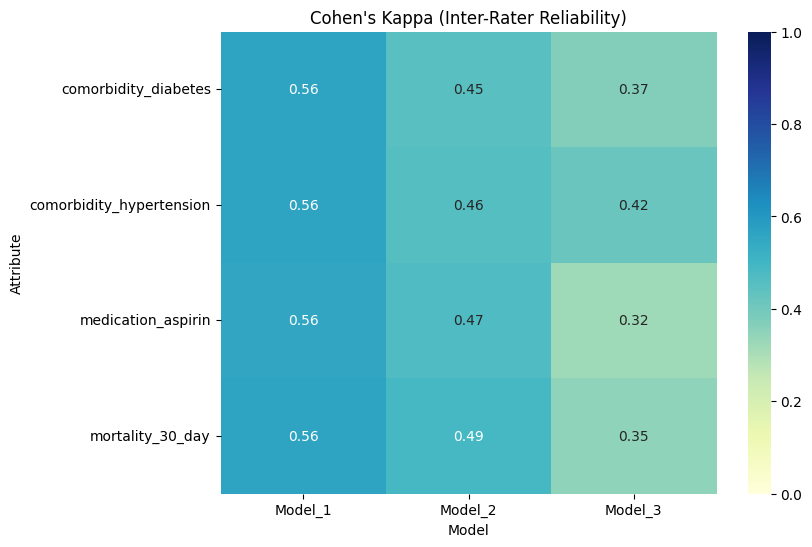

In [172]:


def plot_kappa_heatmap(kappa_df):
    heatmap_data = kappa_df.pivot(index='Attribute', columns='Model', values="Cohen's Kappa")
    plt.figure(figsize=(8,6))
    sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', vmin=0, vmax=1)
    plt.title("Cohen's Kappa (Inter-Rater Reliability)")
    plt.show()

# Example usage:
plot_kappa_heatmap(kappa_summary)


In [173]:


def create_pdf_from_images(image_files, output_pdf="model_evaluation_report.pdf"):
    pdf = FPDF()

    for img_file in image_files:
        cover = Image.open(img_file)
        width, height = cover.size

        # Convert pixels to mm with 1px=0.264583 mm
        width, height = width * 0.264583, height * 0.264583

        # Ensure page is portrait
        orientation = 'P' if width <= height else 'L'
        pdf.add_page(orientation=orientation)

        # Resize image to fit page
        pdf.image(img_file, x=0, y=0, w=210 if orientation=='P' else 297)

    pdf.output(output_pdf, "F")
    print(f"PDF report saved as {output_pdf}")


In [174]:
image_files = ['F1 bar_chart.png', 'pr_curve.png', 'summary_metrics.png']

In [175]:
create_pdf_from_images(image_files)

PDF report saved as model_evaluation_report.pdf
